In this notebook we will build an artificial neural net from scratch which will be trained on the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) containing hand-written digits 0-9. We will access the dataset through [keras](keras.io).

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
mnist = tf.keras.datasets.mnist
(x, y), (x_val, y_val) = mnist.load_data()
x = tf.keras.utils.normalize(x, axis=1)
x_val = tf.keras.utils.normalize(x_val, axis=1)

Each data point in _**x**_ is a 28x28 matrix whose elements correspond to the intensity on a gray scale. Each matrix is paired with a label which we store in _**y**_. This is what one data point looks like

(<matplotlib.image.AxesImage at 0x103cd4350>, 3)

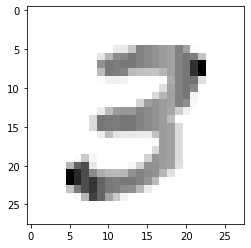

In [4]:
plt.imshow(x[7], cmap=plt.cm.binary), y[7]

We will leave only 3's and 7's. We will also turn the labels into booleans (i.e. 1 for '3', 0 for '7')

In [5]:
y_3vs7 = np.array([yi for yi in y if yi==3 or yi==7])
y_3vs7bin = np.array([1 if yi==3 else 0 for yi in y_3vs7])
x_3vs7 = np.array([xi for xi, yi in zip(x, y) if yi==3 or yi==7])
y_val_3vs7 = np.array([yi for yi in y_val if yi==3 or yi==7])
y_val_3vs7bin = np.array([1 if yi==3 else 0 for yi in y_val_3vs7])
x_val_3vs7 = np.array([xi for xi, yi in zip(x_val, y_val) if yi==3 or yi==7])
x_3vs7.shape, len(y_3vs7)

((12396, 28, 28), 12396)

We will flatten the last two dimensions so that 28x28 matrices will be 784-element-long vectors

In [6]:
x_3vs7_2d = x_3vs7.reshape(-1, 28*28)
x_3vs7_2d.shape

(12396, 784)

Our simple neural net will contain one layer with a linear function **xb** x **weights** + **bias** where we also apply `sigmoid` in order to transform the output to (0,1) interval. In the second layer, if the transformed output is greater than 0.5 the image is considered to be of '3', otherwise - '7'.

In [7]:
class MyNet:
    def __init__(self, size, mu=0, std=1.0):        
        self.weights = np.random.normal(mu, std, size)
        self.bias = np.random.normal(mu, std, 1)
        
    def update_parameters(self, weights_grad, bias_grad, lr):
        self.weights -= weights_grad*lr
        self.bias -= bias_grad*lr        
    
    def linear(self, x):
        return x@self.weights + self.bias
        
    def sigmoid(self, x): return 1 / (1 + np.exp(-x))
    
    # first layer of the net
    def predict(self, x):
        return self.sigmoid(self.linear(x))
    
    # final layer of the net whith two states (either 3 or 7)
    def is3(self, x):
        if len(x) == 1:
            if self.predict(x)>0.5:
                print("Yes, it's 3")
            else:
                print("No, it's 7")
        else:
            print("Multiple images selected")        
        
    def accuracy(self, x, labels):
        correct = (self.predict(x)>0.5) == labels
        return correct.mean()    

The loss function of our prediction. It measures the margin of our predictions against the targets (labels)

In [8]:
def mnist_loss(model, x, targets):
    preds = model.predict(x)
    loss = np.array([1-p if t==1 else p for p, t in zip(preds, targets)])
    return loss.mean()

In order to find an optimal set of model parameters (weights & bias) we need to determine the behavior of the loss function subject to change in model parameters. Such a behavior is quantified by what is known as _gradient_. To find the gradient, we need to calculate the derivative at each element of the vector **weights** and **bias**. We will use a finite-difference approximation for the derivative of a function **f**: 

(**f**(**model_parameters**+**dx**) - **f**(**model_parameters**-**dx**)) / (2***dx**),

where **dx**=0.001

In [9]:
def mnist_loss_grad(model, batch, labels):
    dx = 0.001
    old_bias = model.bias.item()
    model.bias = old_bias + dx
    loss_up = mnist_loss(model, batch, labels)
    model.bias = old_bias - dx
    loss_down = mnist_loss(model, batch, labels)
    bias_grad = (loss_up - loss_down)/2/dx
    model.bias = np.array([old_bias])
    
    N = len(model.weights)
    weights_grad = np.zeros(N)
    for i in range(N):
        old_weight = model.weights[i].item() # saving the weight
        model.weights[i] = old_weight + dx
        loss_up = mnist_loss(model, batch, labels)
        model.weights[i] = old_weight - dx
        loss_down = mnist_loss(model, batch, labels)  
        weights_grad[i] = (loss_up - loss_down)/2/dx
        model.weights[i] = old_weight # returning to the old value       
    
    return weights_grad, bias_grad

Now that we have a gradient we can start training our model. We will update the model parameters like so

**parameters** -= **gradient** x **lr**,

where **lr** is a learning rate. This operation is implemented in `MyNet` component function `update_parameters`.

In [10]:
def train_epoch(data, model, lr=1., batch_size=100):
    x, y = data
    for b in range(batch_size):
        index_range = slice(b*batch_size,(b+1)*batch_size)
        batch = x[index_range]
        labels = y[index_range]
        
        weights_grad, bias_grad = mnist_loss_grad(model, batch, labels)
        model.update_parameters(weights_grad, bias_grad, lr)

The function above will take in the following required parameters: data - (x,y) tuple; model - (`MyNet` object). After we trained the model, we should estimate how well our predictions are. We will do that via `MyNet` component function `accuracy`

In [11]:
def model_fit(train_data, test_data, model, epochs):
    x, y = test_data
    print("accuracy before training:", model.accuracy(x, y))
    for epoch in range(epochs):        
        train_epoch(train_data, model)
        print("epoch", epoch+1, ", accuracy:", model.accuracy(x, y))

We will split our data into a training and testing set. The usual practice is such about 80% is used for training.

In [12]:
ind = 9917 # about 80% of the original set
train_data = x_3vs7_2d[:ind], y_3vs7bin[:ind]
test_data = x_3vs7_2d[ind:], y_3vs7bin[ind:]

Creating a `MyNet` object and initializing it to 784 random initial weights + bias

In [13]:
mynet = MyNet(28*28)

Training the model for 3 epochs

In [14]:
model_fit(train_data, test_data, mynet, epochs=3)

accuracy before training: 0.49415086728519564
epoch 1 , accuracy: 0.9233561920129084
epoch 2 , accuracy: 0.9499798305768455
epoch 3 , accuracy: 0.9576442113755547


After we achieved a satisfactory accuracy, let's see how our model is able to recognize the images. We will pick an arbitrary image from x_val_3vs7 data set which was not part of our training or testing set so the model never saw it. `MyNet` component function `is3` is implementing the final layer of the neural net, where the question "Is this 3?" is asked.

Yes, it's 3


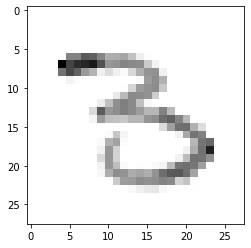

In [15]:
x_ind = 125 # try a different image here
plt.imshow(x_val_3vs7[x_ind], cmap=plt.cm.binary)
mynet.is3(x_val_3vs7[x_ind].reshape(-1, 28*28))